In [2]:
import pandas as pd

In [3]:
notes_raw = pd.read_csv("../data/notes-00000.tsv", sep="\t")
notes_topic = pd.read_parquet("./outputs/notes_with_topics.parquet", engine="pyarrow")

C:\Users\jguo27\AppData\Local\Temp\ipykernel_4856\1544562928.py:1: DtypeWarning: Columns (0: believable, 1: harmful, 2: validationDifficulty) have mixed types. Specify dtype option on import or set low_memory=False.
  notes_raw = pd.read_csv("../data/notes-00000.tsv", sep="\t")


In [4]:
print("Shape of notes_raw:", notes_raw.shape)
print("Shape of notes_topic:", notes_topic.shape)

Shape of notes_raw: (2347611, 24)
Shape of notes_topic: (2347608, 6)


In [5]:
notes = notes_topic.merge(
    notes_raw,
    on="noteId",
    how="left",
    validate="one_to_one"
)


In [6]:
notes_raw.columns

Index(['noteId', 'noteAuthorParticipantId', 'createdAtMillis', 'tweetId',
       'classification', 'believable', 'harmful', 'validationDifficulty',
       'misleadingOther', 'misleadingFactualError',
       'misleadingManipulatedMedia', 'misleadingOutdatedInformation',
       'misleadingMissingImportantContext', 'misleadingUnverifiedClaimAsFact',
       'misleadingSatire', 'notMisleadingOther',
       'notMisleadingFactuallyCorrect',
       'notMisleadingOutdatedButNotWhenWritten', 'notMisleadingClearlySatire',
       'notMisleadingPersonalOpinion', 'trustworthySources', 'summary',
       'isMediaNote', 'isCollaborativeNote'],
      dtype='str')

In [5]:
note2topic = notes.set_index("noteId")["topic"]


In [6]:
import pandas as pd
from pathlib import Path

TOPK = 10
top_topics = notes["topic"].value_counts(dropna=False).head(TOPK).index.tolist()

rating_files = sorted(Path("../data").glob("ratings-*.tsv"))

top_counts = pd.Series(0, index=top_topics, dtype="int64")
other_count = 0

total_rows = 0
total_mapped = 0

for f in rating_files:
    for chunk in pd.read_csv(f, sep="\t", usecols=["noteId"], chunksize=2_000_000):
        total_rows += len(chunk)

        topics = chunk["noteId"].map(note2topic).dropna()
        total_mapped += len(topics)

        vc = topics.value_counts()

        top_counts = top_counts.add(vc.reindex(top_topics, fill_value=0), fill_value=0).astype("int64")

        other_count += int(vc.sum() - vc.reindex(top_topics, fill_value=0).sum())

rating_counts = top_counts.copy()
rating_counts["Other Topics"] = other_count

ratings_frac = (rating_counts / rating_counts.sum()) * 100

print("total ratings rows read:", total_rows)
print("total ratings mapped:", total_mapped)
ratings_frac.sort_values(ascending=False)


total ratings rows read: 196388856
total ratings mapped: 176844986


news_&_social_concern       70.805313
science_&_technology         4.181277
diaries_&_daily_life         3.777016
Other Topics                 3.710159
fitness_&_health             3.290402
sports                       3.254395
business_&_entrepreneurs     3.179328
celebrity_&_pop_culture      2.575536
film_tv_&_video              2.497998
other_hobbies                1.732573
gaming                       0.996002
dtype: float64

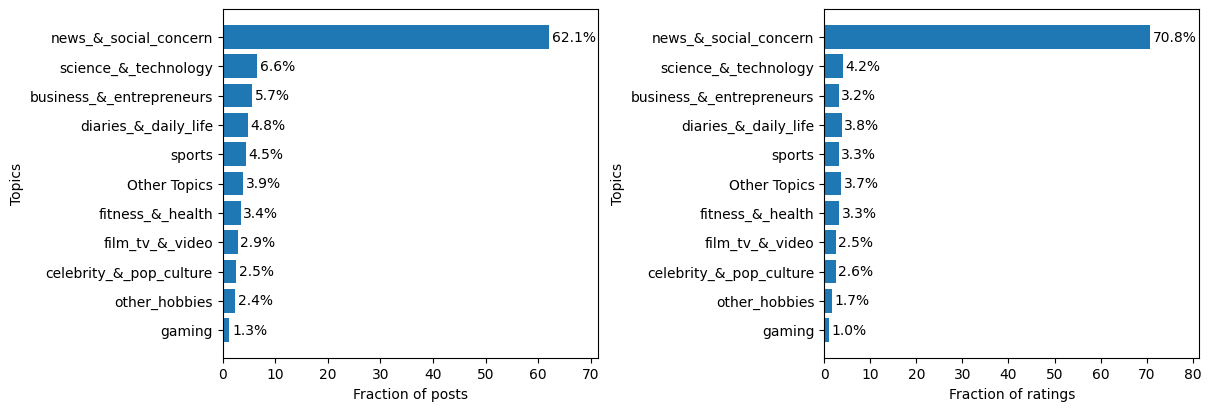

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

TOPK = 10

post_counts = notes["topic"].value_counts(dropna=False)
top_topics = post_counts.head(TOPK).index.tolist()

posts_topic_plot = notes["topic"].where(notes["topic"].isin(top_topics), "Other Topics")
posts_frac = posts_topic_plot.value_counts(normalize=True).sort_values(ascending=False) * 100


ratings_frac_plot = ratings_frac.reindex(posts_frac.index, fill_value=0)

def _barh_with_pct(ax, series_pct, xlabel):
    ax.barh(series_pct.index, series_pct.values)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Topics")

    for y, v in enumerate(series_pct.values):
        ax.text(v + 0.5, y, f"{v:.1f}%", va="center")

    ax.set_xlim(0, max(10, series_pct.max() * 1.15))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

_barh_with_pct(axes[0], posts_frac, "Fraction of posts")
_barh_with_pct(axes[1], ratings_frac_plot, "Fraction of ratings")

plt.show()
